## Kajal Tiwary
## ANLY-590 Final Project
## EDA & Regression Models 

In [86]:
## Import all necessary libraries
!pip install wordninja
import pandas as pd
import numpy as np
import wordninja
import os
from nltk.tokenize import RegexpTokenizer
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import roc_curve, auc, roc_auc_score

You should consider upgrading via the '/Users/kajaltiwary/miniforge3/envs/TF/bin/python -m pip install --upgrade pip' command.


## Data Preparation (taken from initial notebook in repository)

In [189]:
## Specify the working directory
os.chdir("/Users/kajaltiwary/Downloads/data 7/raw")

In [190]:
## Rename columns such that they are easy to interpret downstream
col_names_complete = ['track_id','race_date','race_number','program_number','trakus_index','latitude',
                      'longitude','distance_id','course_type','track_condition','run_up_distance','race_type',
                      'unknown', 'post_time', 'weight_carried','jockey','odds','position_at_finish']
col_names_start = ['track_id','race_date','race_number','program_number','weight_carried','jockey',
                   'odds','position_at_finish']

In [191]:
## Load in all of the datasets
complete = pd.read_csv('nyra_2019_complete_raw.csv', names = col_names_complete, index_col=False)
start = pd.read_csv('nyra_start_table_raw.csv', names = col_names_start, index_col=False)
race = pd.read_csv('nyra_race_table_raw.csv', index_col=False)
tracking = pd.read_csv('nyra_tracking_table_raw.csv', index_col=False)
pdf = pd.read_csv('historical_results.csv', index_col=False)
aqu = pd.read_csv('weather_data/aqu.csv')
bel = pd.read_csv('weather_data/bel.csv')
sar = pd.read_csv('weather_data/sar.csv')

/var/folders/dl/_b_ww5_5059_xnshf6_d2b040000gn/T/ipykernel_8744/2598141898.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  complete = pd.read_csv('nyra_2019_complete_raw.csv', names = col_names_complete, index_col=False)


In [192]:
## Change the data type for columns
race['distance_id'] = race['distance_id'].astype('int64')
race['run_up_distance'] = race['run_up_distance'].astype('int64')
race['purse'] = race['purse'].astype('int64')
start['program_number'] = start['program_number'].apply(lambda x : x.replace(" ", ""))

In [193]:
## Determine the right location to separate the column
def find_numeric(string):
    place = False
    for i in range(0, len(string)):
        if not string[i].isalpha():
            continue
        else:
            return i + 5

In [194]:
## Clean up the scraped pdf csv file 
pdf['LastRaced'] = pdf['LastRaced'].replace('---', np.nan, regex=True)
pdf['Track'] = pdf['Track'].apply(lambda x : x[0:3])
pdf['last_race_track'] = pdf['LastRaced'].apply(lambda x : x[-4:-1] if x is not np.nan else np.nan)
pdf['last_race_date'] = pd.to_datetime(pdf['LastRaced'].apply(lambda x : x[0 : find_numeric(x)] if x is not np.nan else np.nan), 
                                       format="%d%b%y", 
                                       errors='coerce')
pdf['Date'] = pd.to_datetime(pdf['Date'], format="%B%d,%Y")
pdf['day_since_last_race'] = pdf['Date'] - pdf['last_race_date']

In [195]:
## Split the commnets into to tokens
res = []
tokenizer = RegexpTokenizer(r'\w+')
for i in pdf.Comments:
    if type(i) == str:
        phrase_list = tokenizer.tokenize(i)
        splited_tokens = [wordninja.split(i) for i in phrase_list]
        flat_splited_tokens = [j for sublist in splited_tokens for j in sublist]
        res.append(flat_splited_tokens)    
    else:
        res.append(np.nan)
pdf['Comments'] = res

In [196]:
## Subset the dataframe and rename columns 
historical_results = pdf[['Track','Date','Race','Pgm','last_race_track','day_since_last_race','Comments']].rename(
    columns = {'Track':'track_id',	'Date':'race_date',	'Race':'race_number',	'Pgm':'program_number'})
historical_results.race_date = historical_results.race_date.astype('str')

In [197]:
## Merge the data frames 
start_race = start.merge(
    race, how = 'left', on=['track_id','race_date','race_number']).merge(
        historical_results, how = 'left', on=['track_id','race_date','race_number','program_number'])

In [198]:
## Merge the weather data
dfmerged = pd.concat([aqu, bel, sar], axis=0, ignore_index=True)
dfmerged = dfmerged.drop(dfmerged.columns[[0]],axis = 1)

In [199]:
## Merge the dataframes
final = pd.merge(start_race, dfmerged,  how='left', left_on=["track_id","race_date"], right_on = ['local','day']).drop(
    ['local', 'day'], axis = 1)

In [200]:
## Show the data frame
final.head(5)

,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,position_at_finish,distance_id,course_type,...,day_since_last_race,Comments,humidity,precipcover,precip,temp,maxt,cloudcover,weathertype,snow
0,AQU,2019-01-01,1,1,123,Dylan Davis,130,2,650,D,...,37 days,"[in, s, dr, ve, 5, 16, out, late]",73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0
1,AQU,2019-01-01,1,2,120,Junior Alvarado,295,3,650,D,...,25 days,"[to, rail, 1, 2, 6, p, 1, 8, mild]",73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0
2,AQU,2019-01-01,1,3,118,Jose Lezcano,180,4,650,D,...,37 days,"[prompted, 2, w, folded]",73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0
3,AQU,2019-01-01,1,4,123,Jomar Garcia,1280,5,650,D,...,17 days,"[3, w, turn, alter, 5, p, 1, 8]",73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0
4,AQU,2019-01-01,1,5,118,Manuel Franco,1150,1,650,D,...,37 days,"[3, 4, w, dr, ve, 5, 16, 4, w, up]",73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0


## Exploratory Data Analysis (Q2 & Q3)

Business Question #2 

In [58]:
## Filter the dataframe and print 
eda2 = final

## Add an additional column for where it rains versus does not 
eda2['rain_flag'] = np.where(eda2['precip'] > 0.0, True, False)
eda2.head()

,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,position_at_finish,distance_id,course_type,...,Comments,humidity,precipcover,precip,temp,maxt,cloudcover,weathertype,snow,rain_flag
0,AQU,2019-01-01,1,1,123,Dylan Davis,130,2,650,D,...,"[in, s, dr, ve, 5, 16, out, late]",73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0,True
1,AQU,2019-01-01,1,2,120,Junior Alvarado,295,3,650,D,...,"[to, rail, 1, 2, 6, p, 1, 8, mild]",73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0,True
2,AQU,2019-01-01,1,3,118,Jose Lezcano,180,4,650,D,...,"[prompted, 2, w, folded]",73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0,True
3,AQU,2019-01-01,1,4,123,Jomar Garcia,1280,5,650,D,...,"[3, w, turn, alter, 5, p, 1, 8]",73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0,True
4,AQU,2019-01-01,1,5,118,Manuel Franco,1150,1,650,D,...,"[3, 4, w, dr, ve, 5, 16, 4, w, up]",73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0,True


[Text(0.5, 1.0, 'Odds Distribution By Track Type')]

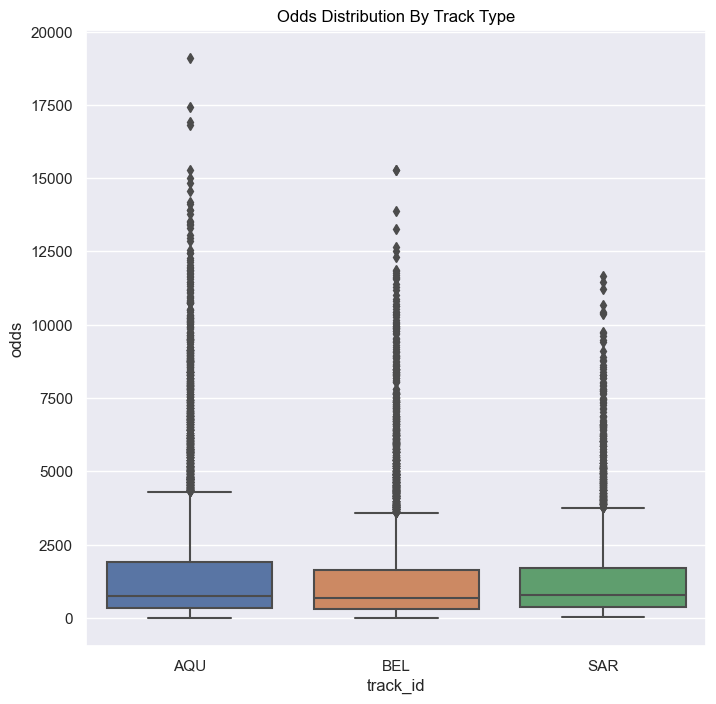

In [64]:
## Develop a plot to examine the distribution across track type 
## Website Used: https://seaborn.pydata.org/generated/seaborn.boxplot.html
import seaborn as sns 
sns.boxplot(x = eda2['track_id'],
            y = eda2['odds']).set(title='Odds Distribution By Track Type')

[Text(0.5, 1.0, 'Odds Distribution By Course Type')]

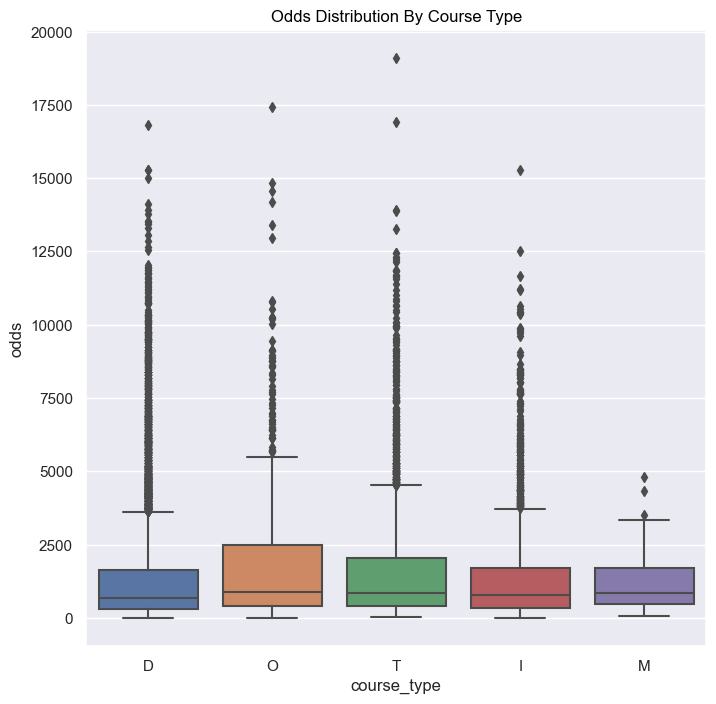

In [65]:
## Develop a plot to examine the distribution across course type 
## Website Used: https://seaborn.pydata.org/generated/seaborn.boxplot.html
import seaborn as sns 
sns.boxplot(x = eda2['course_type'],
            y = eda2['odds']).set(title='Odds Distribution By Course Type')

[Text(0.5, 1.0, 'Odds Distribution By Whether Or Not It Rained')]

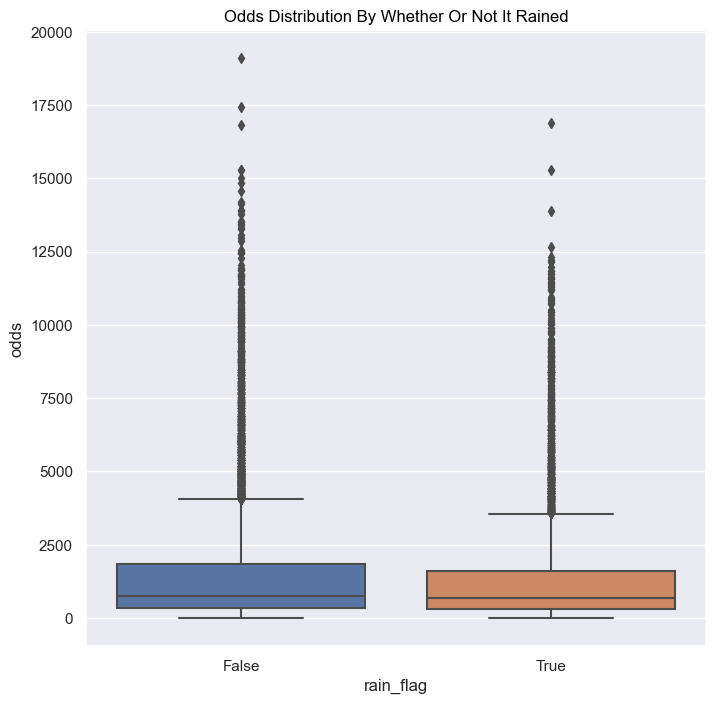

In [66]:
## Develop a plot to examine the distribution across whether or not it rained 
## Website Used: https://seaborn.pydata.org/generated/seaborn.boxplot.html
import seaborn as sns 
sns.boxplot(x = eda2['rain_flag'],
            y = eda2['odds']).set(title='Odds Distribution By Whether Or Not It Rained')

Business Question 3

In [68]:
## Add another variable based on whether or not it snowed 
eda3 = eda2
eda3['snow_flag'] = np.where(eda3['snow'] > 0.0, True, False)
eda3.head()

,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,position_at_finish,distance_id,course_type,...,humidity,precipcover,precip,temp,maxt,cloudcover,weathertype,snow,rain_flag,snow_flag
0,AQU,2019-01-01,1,1,123,Dylan Davis,130,2,650,D,...,73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0,True,False
1,AQU,2019-01-01,1,2,120,Junior Alvarado,295,3,650,D,...,73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0,True,False
2,AQU,2019-01-01,1,3,118,Jose Lezcano,180,4,650,D,...,73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0,True,False
3,AQU,2019-01-01,1,4,123,Jomar Garcia,1280,5,650,D,...,73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0,True,False
4,AQU,2019-01-01,1,5,118,Manuel Franco,1150,1,650,D,...,73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0,True,False


[Text(0.5, 1.0, 'Purse Distribution By Whether Or Not It Snowed')]

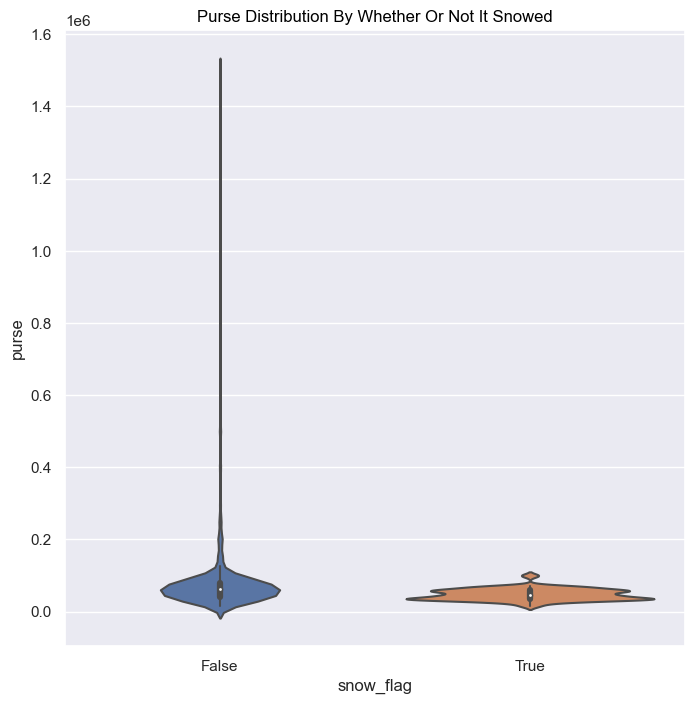

In [71]:
## Show the distribution of purse based on whether or not it snowed 
## Website used: https://seaborn.pydata.org/generated/seaborn.violinplot.html
import seaborn as sns 
sns.violinplot(x = eda3['snow_flag'],
            y = eda3['purse']).set(title='Purse Distribution By Whether Or Not It Snowed')

[Text(0.5, 1.0, 'Purse Distribution By Course Type')]

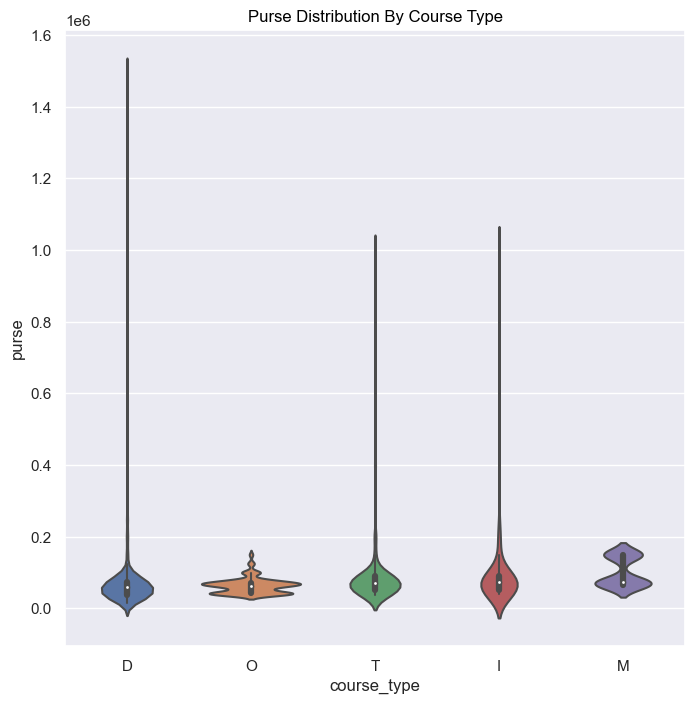

In [73]:
## Show the distribution of purse by course type 
## Website used: https://seaborn.pydata.org/generated/seaborn.violinplot.html
import seaborn as sns 
sns.violinplot(x = eda3['course_type'],
            y = eda3['purse']).set(title='Purse Distribution By Course Type')

[Text(0.5, 1.0, 'Purse Distribution By Track Type')]

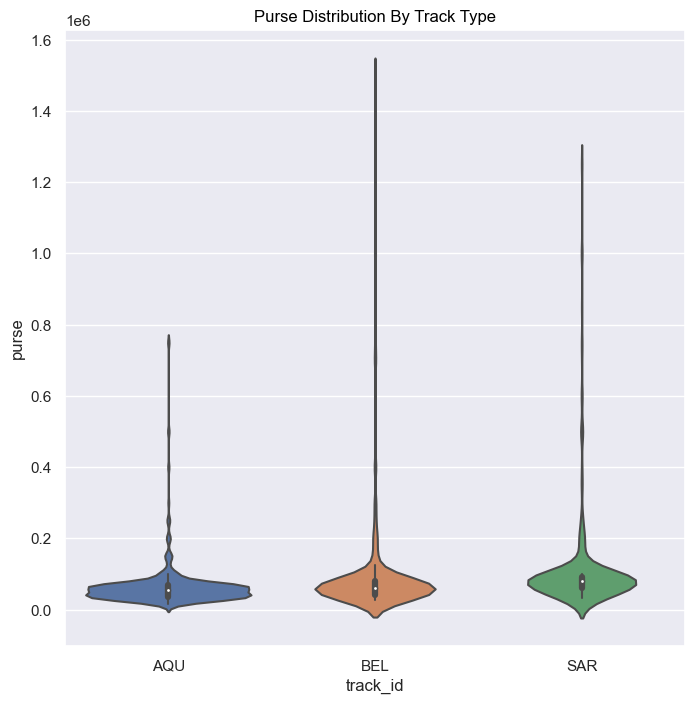

In [74]:
## Show the distribution of purse by track type 
## Website used: https://seaborn.pydata.org/generated/seaborn.violinplot.html
import seaborn as sns 
sns.violinplot(x = eda3['track_id'],
            y = eda3['purse']).set(title='Purse Distribution By Track Type')

[Text(0.5, 1.0, 'Purse Distribution By Whether Or Not It Rained')]

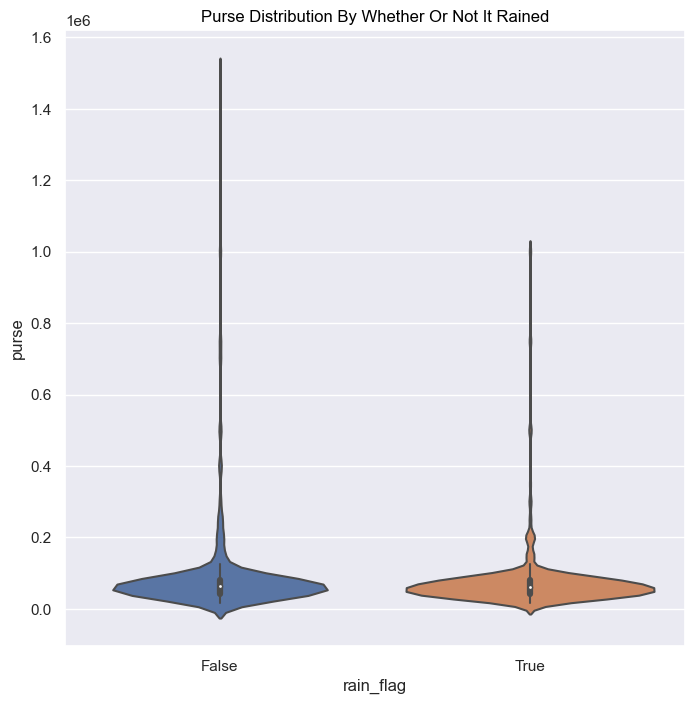

In [75]:
## Show the distribution of purse based on whether or not it rained 
## Website used: https://seaborn.pydata.org/generated/seaborn.violinplot.html
sns.violinplot(x = eda3['rain_flag'],
            y = eda3['purse']).set(title='Purse Distribution By Whether Or Not It Rained')

### ML Regression - PreProcessing

In [512]:
## Load in the combined data frame 
final = pd.read_csv("/Users/kajaltiwary/Downloads/joined_data_without_position.csv")
final.head()

,Unnamed: 0,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,position_at_finish,distance_id,...,Comments,seconds_in_race,humidity,precipcover,precip,temp,maxt,cloudcover,weathertype,snow
0,0,AQU,2019-01-01,1,1,123,Dylan Davis,130,2,650,...,"ins,drve5/16,outlate",79.0,73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0
1,1,AQU,2019-01-01,1,2,120,Junior Alvarado,295,3,650,...,"torail1/2,6p1/8,mild",79.0,73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0
2,2,AQU,2019-01-01,1,3,118,Jose Lezcano,180,4,650,...,"prompted2w,folded",79.0,73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0
3,3,AQU,2019-01-01,1,4,123,Jomar Garcia,1280,5,650,...,"3wturn,alter5p1/8",79.0,73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0
4,4,AQU,2019-01-01,1,5,118,Manuel Franco,1150,1,650,...,"3-4w,drve5/16,4w,up",79.0,73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0


In [513]:
## View column names
final.columns

Index(['Unnamed: 0', 'track_id', 'race_date', 'race_number', 'program_number',
       'weight_carried', 'jockey', 'odds', 'position_at_finish', 'distance_id',
       'course_type', 'track_condition', 'run_up_distance', 'race_type',
       'purse', 'post_time', 'last_race_track', 'day_since_last_race',
       'Comments', 'seconds_in_race', 'humidity', 'precipcover', 'precip',
       'temp', 'maxt', 'cloudcover', 'weathertype', 'snow'],
      dtype='object')

In [514]:
## Examine data types 
final.dtypes

Unnamed: 0               int64
track_id                object
race_date               object
race_number              int64
program_number          object
weight_carried           int64
jockey                  object
odds                     int64
position_at_finish       int64
distance_id              int64
course_type             object
track_condition         object
run_up_distance          int64
race_type               object
purse                    int64
post_time                int64
last_race_track         object
day_since_last_race     object
Comments                object
seconds_in_race        float64
humidity               float64
precipcover            float64
precip                 float64
temp                   float64
maxt                   float64
cloudcover             float64
weathertype             object
snow                   float64
dtype: object

In [515]:
## Remove "days" from day_since_last_race variable
final["day_since_last_race"] = final["day_since_last_race"].str[:2]
final["day_since_last_race"]

0        37
1        25
2        37
3        17
4        37
         ..
15076    45
15077    25
15078    18
15079    50
15080    50
Name: day_since_last_race, Length: 15081, dtype: object

In [516]:
# Get number of unique values per feature to see which are categorical vs. continuous
n = final.nunique(axis=0)
print("Number of unique values in each column: \n", n)

Number of unique values in each column: 
 Unnamed: 0             15081
track_id                   3
race_date                217
race_number               13
program_number            20
weight_carried            35
jockey                   178
odds                     656
position_at_finish        14
distance_id               20
course_type                5
track_condition            7
run_up_distance          127
race_type                 12
purse                     70
post_time                360
last_race_track          182
day_since_last_race       97
Comments                9957
seconds_in_race          447
humidity                 215
precipcover               21
precip                    53
temp                     172
maxt                     184
cloudcover               186
weathertype               50
snow                       6
dtype: int64


In [517]:
#### Remove redundant variables
final = final.drop(columns=['position_at_finish', 'post_time', 'distance_id'])

# Convert the race number as string.
final['race_number'] = final['race_number'].astype('str')

# Fill day since last race with NA
final['day_since_last_race'] = final['day_since_last_race'].fillna(0)

# Fill the comments column with string None.
final['Comments'] = final['Comments'].fillna('None')

In [518]:
## Encode the categorical variables
## First, change the type of the specified columns to "category". This will assign a "code" to each unique category value.
categorical_columns = ["track_id", "race_date", "jockey", "course_type", "track_condition", "race_type", "last_race_track",
                       "weathertype","program_number"]

for col in categorical_columns:
    final[col] = final[col].astype('category') # Set type to category
    final[col] = final[col].cat.codes # replace the strings with their code values.

# View new dataframe
final

,Unnamed: 0,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,course_type,track_condition,...,Comments,seconds_in_race,humidity,precipcover,precip,temp,maxt,cloudcover,weathertype,snow
0,0,0,0,1,0,123,42,130,0,3,...,"ins,drve5/16,outlate",79.00,73.59,20.83,0.30,50.5,59.1,67.6,39,0.0
1,1,0,0,1,10,120,103,295,0,3,...,"torail1/2,6p1/8,mild",79.00,73.59,20.83,0.30,50.5,59.1,67.6,39,0.0
2,2,0,0,1,12,118,96,180,0,3,...,"prompted2w,folded",79.00,73.59,20.83,0.30,50.5,59.1,67.6,39,0.0
3,3,0,0,1,14,123,83,1280,0,3,...,"3wturn,alter5p1/8",79.00,73.59,20.83,0.30,50.5,59.1,67.6,39,0.0
4,4,0,0,1,15,118,119,1150,0,3,...,"3-4w,drve5/16,4w,up",79.00,73.59,20.83,0.30,50.5,59.1,67.6,39,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15076,15076,2,143,11,12,119,119,1470,0,5,...,"chased3-4w,mildkick",83.25,84.02,66.67,0.75,65.6,71.8,71.5,42,0.0
15077,15077,2,143,11,14,119,96,1070,0,5,...,"2w1/4,bytiredfoes",83.25,84.02,66.67,0.75,65.6,71.8,71.5,42,0.0
15078,15078,2,143,11,16,119,50,1130,0,5,...,"coaxed3-4w,fell1/8p",69.25,84.02,66.67,0.75,65.6,71.8,71.5,42,0.0
15079,15079,2,143,11,17,119,66,460,0,5,...,"2w1/4p,tired",83.25,84.02,66.67,0.75,65.6,71.8,71.5,42,0.0


In [519]:
## Convert numerical features to floats
final = final.astype({'weight_carried':'float','odds':'float', 'run_up_distance':'float', 'purse':'float', 'race_number':'float',
                                'seconds_in_race':'float','humidity':'float',
                                'precipcover':'float','precip':'float','temp':'float','maxt':'float','cloudcover':'float',
                                'snow':'float',"day_since_last_race":'float'}, errors = "ignore")

## View the final data types 
final.dtypes

Unnamed: 0               int64
track_id                  int8
race_date                int16
race_number            float64
program_number            int8
weight_carried         float64
jockey                   int16
odds                   float64
course_type               int8
track_condition           int8
run_up_distance        float64
race_type                 int8
purse                  float64
last_race_track          int16
day_since_last_race    float64
Comments                object
seconds_in_race        float64
humidity               float64
precipcover            float64
precip                 float64
temp                   float64
maxt                   float64
cloudcover             float64
weathertype               int8
snow                   float64
dtype: object

In [520]:
## Remove variables we're not using in analysis 
final = final.drop(columns=["Unnamed: 0","race_number","seconds_in_race","race_date"])

In [521]:
## Preprocess the comments and tokenize the words 
import re
import num2words
res = []
tokenizer = RegexpTokenizer(r'\w+')
for i in final.Comments:
    if type(i) == str:
        re.sub(r"(\d+)", lambda x: num2words.num2words(int(x.group(0))), i)
        phrase_list = tokenizer.tokenize(i)
        splited_tokens = [wordninja.split(i) for i in phrase_list]
        flat_splited_tokens = [j for sublist in splited_tokens for j in sublist]
        res.append(flat_splited_tokens)    
    else:
        res.append(np.nan)

In [522]:
## Make TFIDF readable
res_str = []
for i in res:
    s = ' '.join(map(str, i))
    res_str.append(s)

final["Comments"] = res_str

In [523]:
## Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

## Tfidf Vectorize the comments column
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
comments_tfidf = tfidf_vectorizer.fit_transform(final['Comments']) 

## Store feature names
feature_names = tfidf_vectorizer.get_feature_names()

/Users/kajaltiwary/miniforge3/envs/TF/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [524]:
## Separate the target variables from the feature variables 
target = final[['odds', 'purse']]
data1 = final.drop(columns = ['odds', 'purse', 'Comments'])

In [525]:
## View the data types once more 
data1.dtypes

track_id                  int8
program_number            int8
weight_carried         float64
jockey                   int16
course_type               int8
track_condition           int8
run_up_distance        float64
race_type                 int8
last_race_track          int16
day_since_last_race    float64
humidity               float64
precipcover            float64
precip                 float64
temp                   float64
maxt                   float64
cloudcover             float64
weathertype               int8
snow                   float64
dtype: object

In [526]:
## Separate the numeric and categorical columns from one another 
cat_col = []
num_col = []

for i in data1.columns:
    if data1[i].dtype == int:
        cat_col.append((i, data1.columns.get_loc(i)))

    elif data1[i].dtype == float:
        num_col.append((i, data1.columns.get_loc(i)))
        

In [527]:
## Use standard scalar to normalize the values 
from sklearn import preprocessing
num_col_name = [j[0] for j in num_col]
cat_col_name = [j[0] for j in cat_col]
se = preprocessing.StandardScaler()
data1[num_col_name] = se.fit_transform(data1[num_col_name])

In [528]:
## Use standard scalar to normalize the values 
se = preprocessing.StandardScaler()
target[['odds', 'purse']] = se.fit_transform(target[['odds', 'purse']])

/var/folders/dl/_b_ww5_5059_xnshf6_d2b040000gn/T/ipykernel_8744/3284232732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[['odds', 'purse']] = se.fit_transform(target[['odds', 'purse']])


In [529]:
## Concatenate categorical and numeric features with vectorized text features
text = comments_tfidf.toarray()
text_df = pd.DataFrame(text, columns=feature_names)
data_text = pd.concat((data1, text_df), axis=1) 

## Regression - Odds Prediction
### Note: Code was adapted from ML & App Deployment Project & HW Code

#### Train-Test Split

In [562]:
import random 
import numpy

## Calculate split sizes
train_size = int(0.8*len(data_text))
val_size = int(0.1*len(data_text))
test_size = len(data_text) - (train_size+val_size)

## Sanity check the sizes
assert((train_size + val_size + test_size)) == len(data_text)

## Create a list of indices for all the samples in the dataset
indices = np.arange(0, len(data_text))

## Shuffle indices randomly
random.shuffle(indices)

## Get list of indices for each of the splits
train_idx = indices[0:train_size]
val_idx = indices[train_size:(train_size+val_size)]
test_idx = indices[(train_size+val_size):]

## Sanity check
assert(len(train_idx) == train_size)
assert(len(test_idx) == test_size)

## With these lists, we can now select the corresponding dataframe rows using:
## e.g., train_df = data_df.iloc[train_idx] 
print('  Training size: {:,}'.format(train_size))
print('Validation size: {:,}'.format(val_size))
print('      Test size: {:,}'.format(test_size))

  Training size: 12,064
Validation size: 1,508
      Test size: 1,509


In [563]:
## Retrieve the labels for each of the splits
y_train = target["odds"].iloc[train_idx]
y_val = target["odds"].iloc[val_idx]
y_test = target["odds"].iloc[test_idx]

## Select the inputs for the different splits 
X_train = data_text.iloc[train_idx]
X_val = data_text.iloc[val_idx]
X_test = data_text.iloc[test_idx]

#### Model #1: Decision Tree

In [564]:
## Create the decision tree model 
## Note: Due to model run/train time, for loops and automated hyperparameter tuning was removed
from sklearn.tree import DecisionTreeRegressor
dt_mse = DecisionTreeRegressor(criterion='mae',
                            splitter='best',
                            max_depth=10, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=100)

## Get the predicted values
dt_mse.fit(X_train, y_train)
y_predict = dt_mse.predict(X_test)

/Users/kajaltiwary/miniforge3/envs/TF/lib/python3.9/site-packages/sklearn/tree/_classes.py:404: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(


In [565]:
## Get final goodness of fit metrics
mae = mean_absolute_error(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)

## Print evaluation metrics
print("Decision Tree Regression in predicting the odds of a race: ")
print("MAE: ", mae)
print("MSE: ", mse)
print("R2: ", r2)

Decision Tree Regression in predicting the odds of a race: 
MAE:  0.6000081721608309
MSE:  1.2884941875112375
R2:  -0.05465284520730074


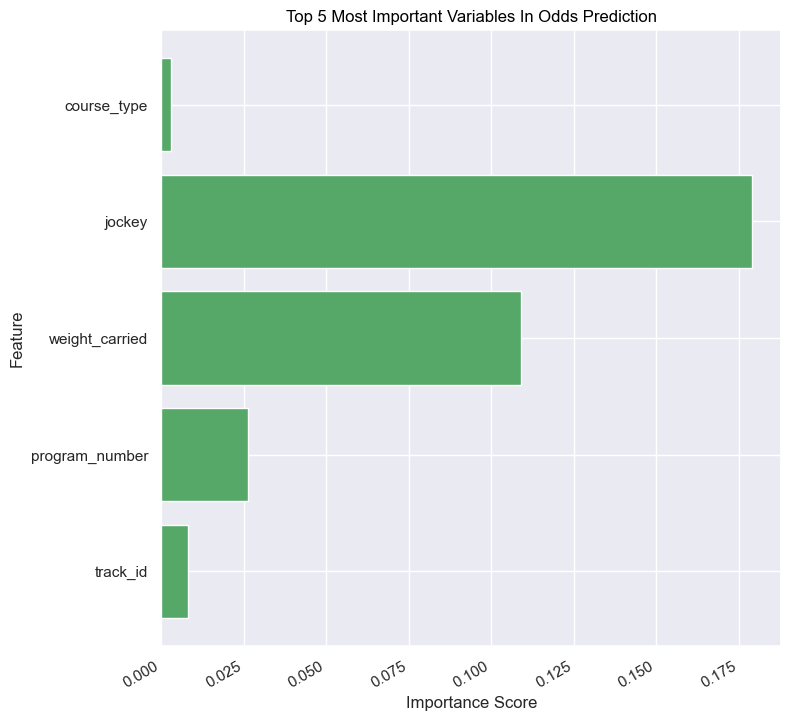

In [566]:
## Get the most important features of the model 
importance = dt_mse.feature_importances_
imp_list = []

## Summarize feature importance
for i, v in enumerate(importance):
    imp_list.append('Feature: %0d, Score: %.5f' % (i,v))

## Convert imp_list to dataframe
imp_df = pd.DataFrame(imp_list, columns=["Feature"])

## Convert to dataframe for interpretability
imp_df = imp_df["Feature"].str.split(",", expand=True)
imp_df.columns = ["Feature", "Importance"]

imp_df["Importance"] = imp_df["Importance"].str[7:]
imp_df["Importance"] = imp_df["Importance"].astype('float')

## Replace feature numbers with feature names
imp_df["Feature"] = X_train.columns

## Plot feature importance
fig, ax = plt.subplots()
plt.barh(imp_df.Feature[:5], imp_df.Importance[:5], color=['r' if v < 0 else 'g' for v in imp_df.Importance])
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title("Top 5 Most Important Variables In Odds Prediction")
plt.ylabel("Feature")
plt.xlabel("Importance Score")
plt.show()

#### Gradient Boost

In [567]:
## Import gradient boosting libraries 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

## Adapted from the ML lecture notes, homework, and project code 
## Use grid search for hyperparameter tuning 
def GB_training_model(X_train, y_train):
        model = GradientBoostingRegressor()
        parameters = {'learning_rate': [0.01,0.02,0.03],
                      'subsample'    : [0.9, 0.5, 0.2],
                      'n_estimators' : [100,500,],
                      'max_depth'    : [2,4,6] }
        grid = GridSearchCV(estimator=model, param_grid = parameters,
                            verbose = 1, n_jobs = -1, refit = True)
        grid.fit(X_train, y_train)
        return(grid.best_estimator_)
    
# Get the best model and train accordingly
best_GB = GB_training_model(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [568]:
## Fit the best model and get evaluation metrics
from sklearn.metrics import r2_score, mean_squared_error
GB_fit = best_GB.fit(X_train, y_train.ravel())
y_pred_GB = GB_fit.predict(X_test)
gbr2 = r2_score(y_test, y_pred_GB)
gbrmse = np.sqrt(mean_squared_error(y_test, y_pred_GB))
gbmse = mean_squared_error(y_test, y_pred_GB)

## Print the evaluation metrics 
print("R2 Score: ", gbr2)
print("RMSE: ", gbrmse)
print("MSE: ", gbmse)

R2 Score:  0.31745223003051404
RMSE:  0.913172855925135
MSE:  0.8338846647984673


In [569]:
## Define a function that gets the most imporant features 
def featureRank_Analysis(model, dataset, cols):
        print()
        print("Feature Importance/Rank Analysis: ")
        X = dataset.loc[:, cols]; X_cols = X.columns.values
        features_imp = model.feature_importances_    
        indices = np.argsort(features_imp)[::-1]
        df = {}
        for f in range(X.shape[1] -1):
            df[f] = [f + 1, indices[f], X_cols[indices[f]], features_imp[indices[f]]]
        df1 = pd.DataFrame.from_dict(df, orient = 'index')
        df1.columns = ['feature_Rank', 'feature_Index', 'feature_Name', 'feature_importance']
        df1 = df1.head(5)
        plt.figure(figsize=(8,6)) 
        plt.barh(df1['feature_Rank'], df1['feature_importance'], tick_label = df1['feature_Name'])
        plt.title("Top 5 Most Important Variables In Odds Prediction")
        plt.ylabel("Feature")
        plt.xlabel("Importance Score")
        plt.show()   


Feature Importance/Rank Analysis: 


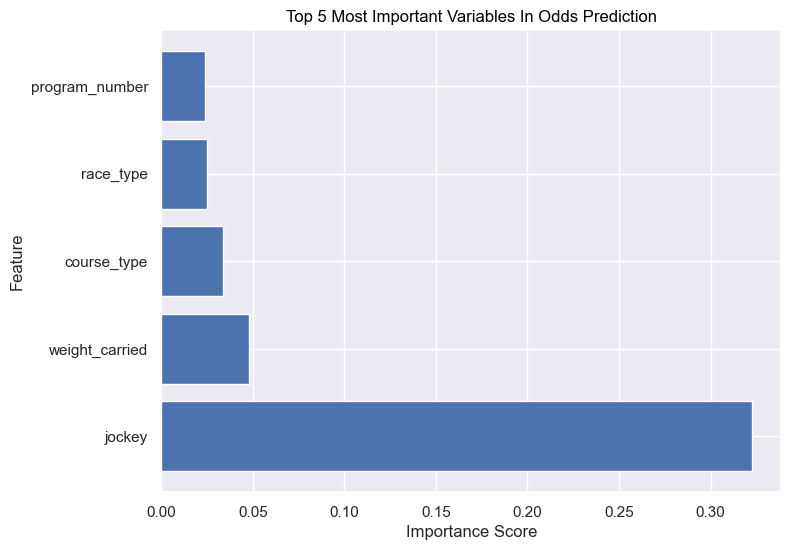

In [570]:
## Get the most important features for the gradient boosting model 
featureRank_Analysis(best_GB, data_text, data_text.columns)

#### XG Boost

In [571]:
## Import XG Boost model 
import xgboost as xgb

## Define an XGBoost function and return the best estimator 
def XG_training_model(X_train, y_train):
        model = xgb.XGBRegressor()
        parameters = {'learning_rate': [0.1,0.01,0.05],
                      'n_estimators' : [100,200,500],
                      'max_depth'    : [2,4,6] 
                      }
        grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, 
                            verbose = 1, n_jobs = -1, refit = True)
        grid.fit(X_train, y_train)
        return(grid.best_estimator_)

## Call the function 
best_XG = XG_training_model(X_train, y_train.ravel())

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [572]:
## Fit model based on the hyperparameter tuning above and train the model
XG_fit = best_XG.fit(X_train, y_train.ravel())

## Get the predictions 
y_pred_XG = XG_fit.predict(X_test)

## Get the evaluation metrics 
xgr2 = r2_score(y_test, y_pred_XG)
xgrmse = np.sqrt(mean_squared_error(y_test, y_pred_XG))
xgmse = mean_squared_error(y_test, y_pred_XG)

## Print the performance metrics 
print("R2 Score: ", xgr2)
print("RMSE: ", xgrmse)
print("MSE: ", xgmse)

R2 Score:  0.32795401545542446
RMSE:  0.9061205143533843
MSE:  0.8210543865320417



Feature Importance/Rank Analysis: 


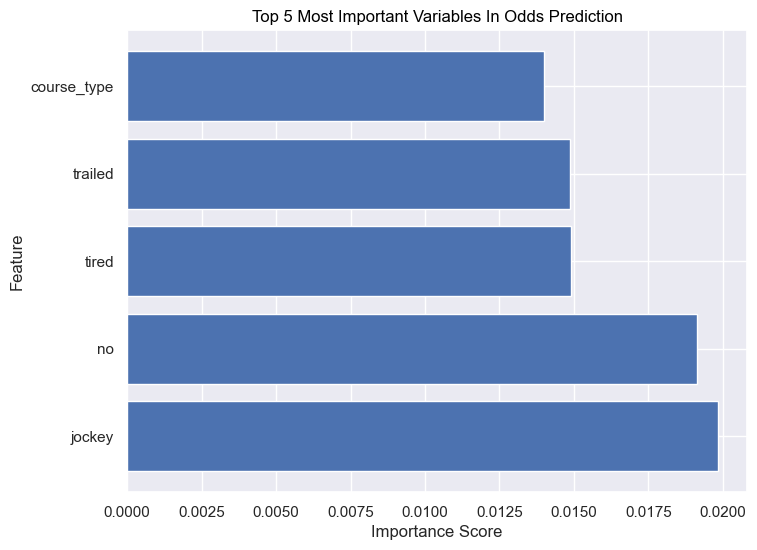

In [573]:
## Get the most important features for the new model 
featureRank_Analysis(best_XG, data_text, data_text.columns)

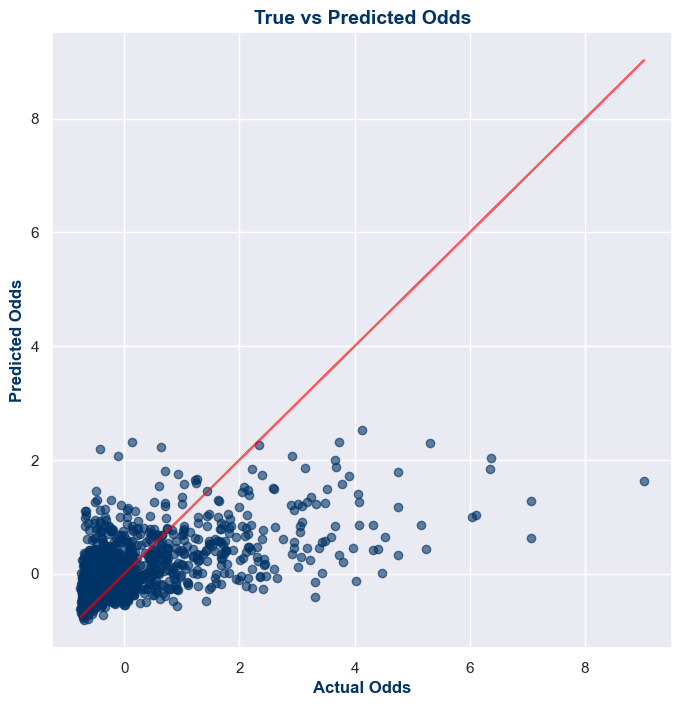

In [575]:
## Get the scatter plot of predicted versus actual 
## This shows the performance of the regression model 
## Note this is only for gradient boost (best performing model)
plt.scatter(y_test,y_pred_XG, color='#003366',alpha=0.6)
plt.title("True vs Predicted Odds", loc='center', fontsize=14,fontweight='bold',color='#003366')
plt.plot(y_test,y_test, color='#FF0000',alpha=0.6)
plt.xlabel("Actual Odds", fontsize=12,fontweight='bold',color='#003366')
plt.ylabel("Predicted Odds", fontsize=12,fontweight='bold',color='#003366')
plt.show()

## Regression - Purse Prediction
### Note: Code was adapted from ML & App Deployment Project & HW Code

In [576]:
# Retrieve the labels for each of the splits 
y_train = target["purse"].iloc[train_idx]
y_val = target["purse"].iloc[val_idx]
y_test = target["purse"].iloc[test_idx]

# Select the inputs for the different splits 
X_train = data_text.iloc[train_idx]
X_val = data_text.iloc[val_idx]
X_test = data_text.iloc[test_idx]

## View the training data 
X_train.head()

,track_id,program_number,weight_carried,jockey,course_type,track_condition,run_up_distance,race_type,last_race_track,day_since_last_race,...,wy,xb,xl,yanked,yb,yd,yearly,yes,yield,yielded
2828,0,0,-1.542377,124,0,1,-0.726129,8,99,0.702737,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6340,1,19,1.001772,42,0,1,-0.563799,0,147,-0.067719,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7503,1,10,1.001772,66,4,0,1.708807,2,170,-0.119082,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5341,0,16,-0.411644,148,0,1,-0.509690,2,99,-0.735446,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10217,1,0,1.567138,42,4,0,2.033465,8,103,2.860011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [577]:
## Define a function for extracting the most important features (as above)
def featureRank_Analysis(model, dataset, cols):
        print()
        print("Feature Importance/Rank Analysis: ")
        X = dataset.loc[:, cols]; X_cols = X.columns.values
        features_imp = model.feature_importances_    
        indices = np.argsort(features_imp)[::-1]
        df = {}
        for f in range(X.shape[1] -1):
            df[f] = [f + 1, indices[f], X_cols[indices[f]], features_imp[indices[f]]]
        df1 = pd.DataFrame.from_dict(df, orient = 'index')
        df1.columns = ['feature_Rank', 'feature_Index', 'feature_Name', 'feature_importance']
        df1 = df1.head(5)
        plt.figure(figsize=(8,6)) 
        plt.barh(df1['feature_Rank'], df1['feature_importance'], tick_label = df1['feature_Name'])
        plt.title("Top 5 Most Important Variables In Purse Prediction")
        plt.ylabel("Feature")
        plt.xlabel("Importance Score")
        plt.show()   

#### Random Forest

In [578]:
## Train the Random Forest algorithm 
## Note: Due to model run/train time, for loops and automated hyperparameter tuning was removed
maes = []
rf_regressor = RandomForestRegressor(n_estimators=5, 
                                        criterion = "mae", 
                                        max_depth = 10, random_state=0)
rf_regressor.fit(X_train, y_train)

# Predict new labels on testing dataset
y_predict = rf_regressor.predict(X_test)

# Get MAE values 
mae = mean_absolute_error(y_test, y_predict)
print("MAE: ", mae)

/Users/kajaltiwary/miniforge3/envs/TF/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(


MAE:  0.12548742861928294


In [579]:
### Get final goodness of fit metrics
mae = mean_absolute_error(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)

## Print the error values 
print("Random forest regression in predicting the purse of a race with 10 trees: ")
print("MAE: ", mae)
print("MSE: ", mse)
print("R2: ", r2)

Random forest regression in predicting the purse of a race with 10 trees: 
MAE:  0.12548742861928294
MSE:  0.3181450096920581
R2:  0.7006851437728474


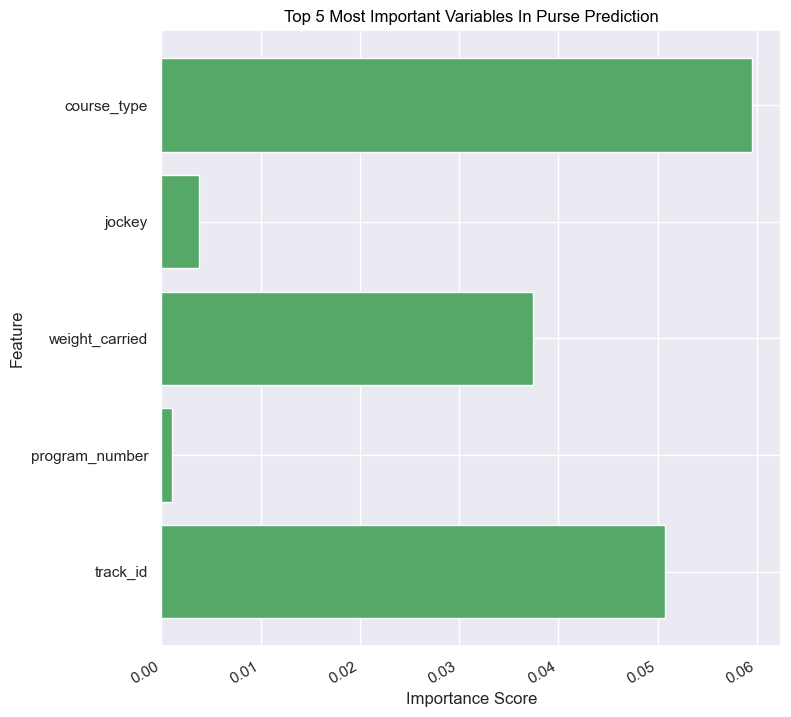

In [580]:
## Extract the features from the model
importance = rf_regressor.feature_importances_
imp_list = []

## Summarize feature importance
for i, v in enumerate(importance):
    imp_list.append('Feature: %0d, Score: %.5f' % (i,v))

## Convert imp_list to dataframe
imp_df = pd.DataFrame(imp_list, columns=["Feature"])


## Convert to dataframe for interpretability
imp_df = imp_df["Feature"].str.split(",", expand=True)
imp_df.columns = ["Feature", "Importance"]
imp_df["Importance"] = imp_df["Importance"].str[7:]
imp_df["Importance"] = imp_df["Importance"].astype('float')

## Replace feature numbers with feature names
imp_df["Feature"] = X_train.columns

## Plot feature importance
fig, ax = plt.subplots()
plt.barh(imp_df.Feature[:5], imp_df.Importance[:5], color=['r' if v < 0 else 'g' for v in imp_df.Importance])
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title("Top 5 Most Important Variables In Purse Prediction")
plt.ylabel("Feature")
plt.xlabel("Importance Score")
plt.show()

#### Gradient Boost

In [581]:
## Import all necessary libraries 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

## Adapted from lecture notes, homework, and project from ML & App Deployment 
## Use grid search to get optimal hyperparameters
def GB_training_model(X_train, y_train):
        model = GradientBoostingRegressor()
        # parameters
        parameters = {'learning_rate': [0.01,0.02,0.03],
                      'subsample'    : [0.9, 0.5, 0.2],
                      'n_estimators' : [100,500,1000],
                      'max_depth'    : [2,4,6] 
                      }
        grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, 
                            verbose = 1, n_jobs = -1, refit = True)
        grid.fit(X_train, y_train)
        return(grid.best_estimator_)
    
## Train the model with the function above
best_GB = GB_training_model(X_train, y_train.ravel())

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [582]:
## Fit the best model and get the predictions
from sklearn.metrics import r2_score, mean_squared_error
GB_fit = best_GB.fit(X_train, y_train.ravel())
y_pred_GB = GB_fit.predict(X_test)
gbr2 = r2_score(y_test, y_pred_GB)
gbrmse = np.sqrt(mean_squared_error(y_test, y_pred_GB))
print("R2 Score: ", gbr2)
print("RMSE: ", gbrmse)

R2 Score:  0.7356969031838481
RMSE:  0.5300288959743964



Feature Importance/Rank Analysis: 


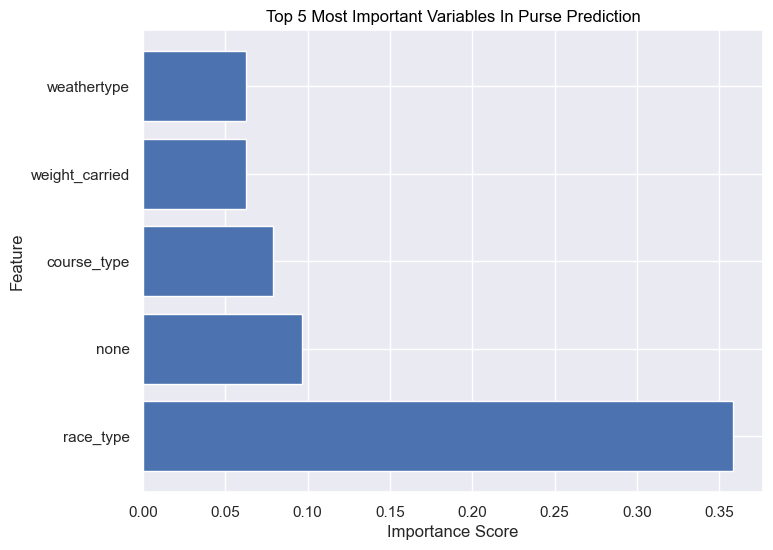

In [583]:
## Extract the most important features
featureRank_Analysis(best_GB, data_text, data_text.columns)

In [584]:
## Get the MSE value in order to compare to other models 
gbmse = mean_squared_error(y_test, y_pred_GB)
print("MSE: ", gbmse)

MSE:  0.2809306305678375


#### XG Boost

In [585]:
## Import necessary libraries 
import xgboost as xgb

## Define a function to train the XG Boost model 
def XG_training_model(X_train, y_train):
        model = xgb.XGBRegressor()
        parameters = {'learning_rate': [0.1,0.01,0.05],
                      'n_estimators' : [100,200,500],
                      'max_depth'    : [2,4,6] 
                      }
        grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, 
                            verbose = 1, n_jobs = -1, refit = True)
        grid.fit(X_train, y_train)
        return(grid.best_estimator_)
    
## Train the model 
best_XG = XG_training_model(X_train, y_train.ravel())

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [586]:
## Fit the model 
XG_fit = best_XG.fit(X_train, y_train.ravel())

## Get the predictions
y_pred_XG = XG_fit.predict(X_test)

## Get the R2 and MSE scores 
xgr2 = r2_score(y_test, y_pred_XG)
xgrmse = np.sqrt(mean_squared_error(y_test, y_pred_XG))

print("R2 Score: ", xgr2)
print("RMSE: ", xgrmse)

R2 Score:  0.7184229412536773
RMSE:  0.5470752345053875



Feature Importance/Rank Analysis: 


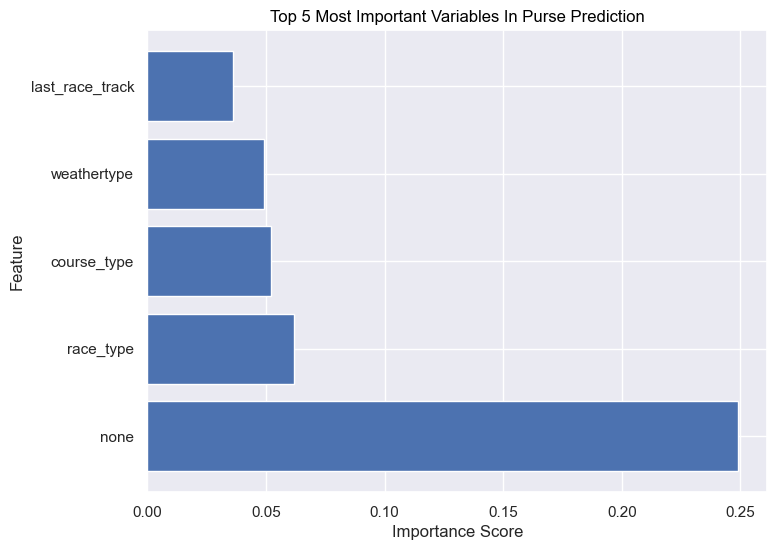

In [587]:
## Get the most important features     
featureRank_Analysis(best_XG, data_text, data_text.columns)

In [588]:
## Print the MSE values 
xgmse = mean_squared_error(y_test, y_pred_XG)
print("MSE: ", xgmse)

MSE:  0.29929131220912475


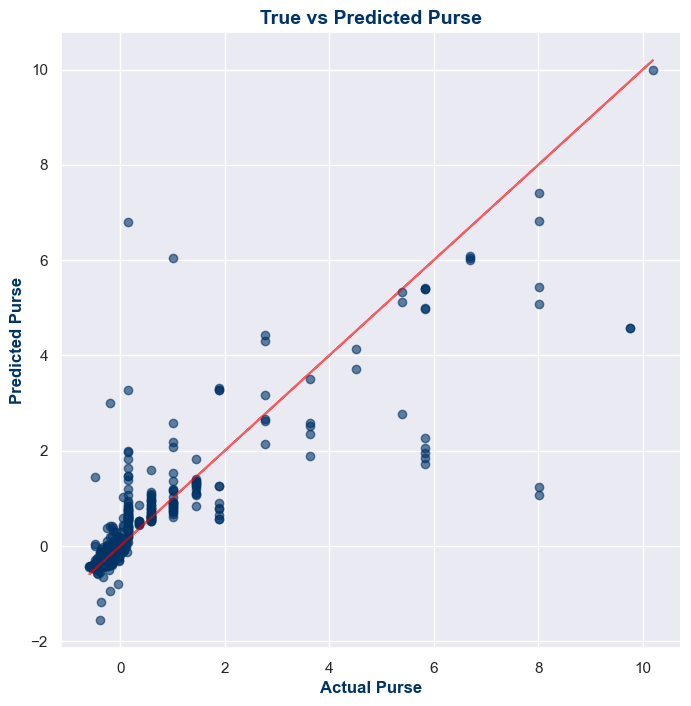

In [589]:
## Plot the performance of the best performing model 
plt.scatter(y_test,y_pred_GB, color='#003366',alpha=0.6)
plt.title("True vs Predicted Purse", loc='center', fontsize=14,fontweight='bold',color='#003366')
plt.plot(y_test,y_test, color='#FF0000',alpha=0.6)
plt.xlabel("Actual Purse", fontsize=12,fontweight='bold',color='#003366')
plt.ylabel("Predicted Purse", fontsize=12,fontweight='bold',color='#003366')
plt.show()